# MIE1624 Assignment 2 

## Sentiment Analysis --- “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?”

## Baizun Shan 1003324324

## Part 1 Data cleaning

o All html tags and attributes (i.e., /<[^>]+>/) are removed.

o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.

o All URLs are removed.

o All characters in the text are in lowercase.

o All stop words are removed. Be clear in what you consider as a stop word. 

o If a tweet is empty after pre-processing, it should be preserved as such.

In [159]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
#nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm import tqdm
#! pip install wordcloud
import wordcloud as wc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load generic tweets dataset
gen_data = pd.read_csv("generic_tweets.txt")
gen_tweets = gen_data['text'].to_frame('text')
gen_data.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Load Canadian elections dataset
can_data = pd.read_csv("Canadian_elections_2019.csv")
can_tweets = can_data['text'].to_frame('text')
can_data.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [4]:
# Data cleaning: Preprocessing text data
# Two helper functions 

# Remove links and punctuations
def clean_text(text):
    # Remove html, http, www. ,etc.
    soup = BeautifulSoup(text,'lxml')
    temp = soup.get_text()
    pattern_1 = '\w+\.\S+'
    temp = re.sub(pattern_1, '', temp)
    pattern_2 = 'https?:\/\/\w+\S+' 
    temp = re.sub(pattern_2, '', temp)
    pattern_3 = 'https?'
    temp = re.sub(pattern_3, '', temp)
    pattern_4 = 'https?:\/\/'
    temp = re.sub(pattern_4, '', temp)
    pattern_5 = 'www\.\w+\S+'
    temp = re.sub(pattern_5, '', temp)
    # Remove punctuation 
    temp = ''.join([c for c in temp if c not in string.punctuation])
    
    return temp

# Tonkenizing, remove stop words, numbers and set words back to root form 
def tokenize(text):
    # Tokenize text: only consider words 
    tokenizer = RegexpTokenizer('[A-z]\w+')
    temp = tokenizer.tokenize(text.lower())
    # Remove stop words
    temp = [w for w in temp if w not in stopwords.words('english')]
    # Lemmatizing---set words back to its root form
    lemmatizer= WordNetLemmatizer()
    temp = [lemmatizer.lemmatize(word) for word in temp]
    
    return temp
    

In [5]:
# Apply helper function to tweets
tqdm.pandas(desc='Cleaning...')
gen_tweets['clean_text'] = gen_tweets['text'].progress_apply(clean_text)
can_tweets['clean_text'] = can_tweets['text'].progress_apply(clean_text)

Cleaning...: 100%|██████████| 2133/2133 [00:00<00:00, 3330.75it/s]


In [6]:
# Check cleaned generic tweets
gen_tweets.head()

,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot Awww thats a bummer You shoulda ...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


In [7]:
# Because all canadian election tweets begin with a meaningless 'b', we strip it.
def can_remove_b(text):
    return text.lstrip('b')

can_tweets['clean_text'] = can_tweets['clean_text'].apply(can_remove_b)
can_tweets.head()

,text,clean_text
0,"b""@RosieBarton So instead of your suggestion, ...",RosieBarton So instead of your suggestion how ...
1,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",AllWomanSpacewalk its realnSpaceStation nEtobi...
2,"b""#Brantford It's going to cost YOU $94 BILLIO...",Brantford Its going to cost YOU 94 BILLION FOR...
3,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",Canada CanadaElection2019 CanadaVotes nelxn43 ...
4,"b""#Canada #taxpayers are sick &amp; tired of h...",Canada taxpayers are sick tired of having the...


In [8]:
# Tokenization

tqdm.pandas(desc='Tokenizing...')
gen_tweets['token_text'] = gen_tweets['clean_text'].progress_apply(tokenize)
can_tweets['token_text'] = can_tweets['clean_text'].progress_apply(tokenize)

Tokenizing...: 100%|██████████| 2133/2133 [00:08<00:00, 244.13it/s]


In [9]:
# See tokenized data
gen_tweets.head()

,text,clean_text,token_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot Awww thats a bummer You shoulda ...,"[switchfoot, awww, thats, bummer, shoulda, got..."
1,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,"[upset, cant, update, facebook, texting, might..."
2,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...,"[kenichan, dived, many, time, ball, managed, s..."
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]"
4,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...,"[nationwideclass, behaving, im, mad, cant, see]"


In [10]:
can_tweets.head()

,text,clean_text,token_text
0,"b""@RosieBarton So instead of your suggestion, ...",RosieBarton So instead of your suggestion how ...,"[rosiebarton, instead, suggestion, agree, cana..."
1,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",AllWomanSpacewalk its realnSpaceStation nEtobi...,"[allwomanspacewalk, realnspacestation, netobic..."
2,"b""#Brantford It's going to cost YOU $94 BILLIO...",Brantford Its going to cost YOU 94 BILLION FOR...,"[brantford, going, cost, billion, next, year, ..."
3,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",Canada CanadaElection2019 CanadaVotes nelxn43 ...,"[canada, canadaelection2019, canadavotes, nelx..."
4,"b""#Canada #taxpayers are sick &amp; tired of h...",Canada taxpayers are sick tired of having the...,"[canada, taxpayer, sick, tired, hard, earned, ..."


## Part 2 Exploratory Analysis

- Design a simple procedure that determines the political party (Liberal, Conservative, NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019 Canadian elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties. What can you say about the distribution of the political affiliations of the tweets?

- Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that visualizes some aspect of the generic tweets and another figure for the 2019 Canadian elections tweets. All graphs and plots should be readable and have all axes that are appropriately labelled.

## Indicator for different parties in 2019 selection

### Liberal Party

Leader: Justin Trudeau

Slogan: "Choose Forward"

Key words: justin, trudeau, justintrudeau, chooseforward, liberal, liberalism, lp

### Conservative Party

leader: Andrew Scheer

Slogan: "It's time for you to get ahead."

Key words: andrew, scheer, andrewscheer, itstimeforyoutogetahead, conservative, conservatism, cp

### New Democratic

leader: Jagmeet Singh

Slogan: "In it for you."

Key words: jagmeet, singh, jagmeetsingh, initforyou, socialdemocracy, newdemoratic, ndp

### Bloc Quebeois

leader: Yves-Francois Blanchet

Slogan: None

Key words: yves, francois, blanchet, quebec, qubeois, blocquebeois, quebecnationalism

### Green Party

leader: Elizabeth May

Slogan: "Not Left. Not Right. Forward Together."

Key words: elizabeth, ellizabethmay, forwardtogether, notleftnotrightforwardtogether, green, gp


In [11]:
#define helper function to see if an election tweet contains key words from a political party
def check_party(text):
    lp_words=['justin','trudeau','justintrudeau','liberal','chooseforward']
    cp_words=['andrew','scheer','andrewscheer','itstimeforyoutogetahead','conservative']
    ndp_words=['jagmeet','singh','jagmeetsingh','initforyou','socialdemocracy','newdemoratic','ndp']
    bq_words=['yves','francois','blanchet','qubeois','blocquebeois','quebecnationalism']
    gp_words=['elizabeth','ellizabethmay','forwardtogether','notleftnotrightforwardtogether','greenparty']
    temp = set(text) 
    lp = set(lp_words) 
    cp = set(cp_words)
    ndp = set(ndp_words)
    bq = set(bq_words)
    gp = set(gp_words)
    
    if (temp & bq): 
        return 'BlocQuebeois' 
    elif (temp & gp):
        return 'Green'
    elif (temp & ndp):
        return 'NDP'
    elif (temp & cp):
        return 'Conservative'
    elif (temp & lp):
        return 'Liberal'
    else: 
        return 'Neutral'

In [12]:
# Create a new columns for party assignment
can_tweets["Party"] = can_tweets['token_text'].apply(check_party)

In [13]:
# Check results 
can_tweets.head()

,text,clean_text,token_text,Party
0,"b""@RosieBarton So instead of your suggestion, ...",RosieBarton So instead of your suggestion how ...,"[rosiebarton, instead, suggestion, agree, cana...",Conservative
1,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",AllWomanSpacewalk its realnSpaceStation nEtobi...,"[allwomanspacewalk, realnspacestation, netobic...",Neutral
2,"b""#Brantford It's going to cost YOU $94 BILLIO...",Brantford Its going to cost YOU 94 BILLION FOR...,"[brantford, going, cost, billion, next, year, ...",Liberal
3,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",Canada CanadaElection2019 CanadaVotes nelxn43 ...,"[canada, canadaelection2019, canadavotes, nelx...",Neutral
4,"b""#Canada #taxpayers are sick &amp; tired of h...",Canada taxpayers are sick tired of having the...,"[canada, taxpayer, sick, tired, hard, earned, ...",Neutral


Political affiliations distribution:
Liberal: 328 (15.377%)
Conservative: 418 (19.597%)
NDP: 138 (6.47%)
BlocQue: 5 (0.234%)
Green: 23 (1.078%)
Neutral: 1221 (57.243%)


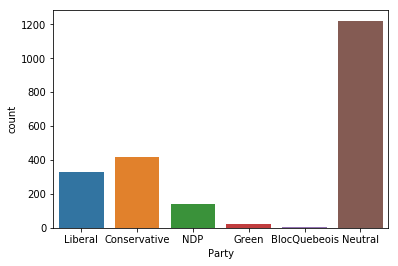

In [14]:
# See distribution of political affiliations of tweets
stat=can_tweets['Party'].value_counts()
print("Political affiliations distribution:\nLiberal: {} ({}%)\nConservative: {} ({}%)\nNDP: {} ({}%)\nBlocQue: {} ({}%)\nGreen: {} ({}%)\nNeutral: {} ({}%)".format\
      (stat[2],round(stat[2]*100/sum(stat),3),stat[1],round(stat[1]*100/sum(stat),3),stat[3],round(stat[3]*100/sum(stat),3),stat[5],round(stat[5]*100/sum(stat),3),\
       stat[4],round(stat[4]*100/sum(stat),3),stat[0],round(stat[0]*100/sum(stat),3)))
ax = sns.countplot(x = 'Party', data = can_tweets, order = ['Liberal','Conservative','NDP','Green','BlocQuebeois','Neutral'])
plt.show()

### Findings on the distribution of political affiliations of tweets

o More than half of tweets do not contain key words from any party. By reading some of neutral tweets, they are more about some specific soical issue, neutral emotions, opinions, etc. This situation may be improved if we use a more professional key words set.

o Among tweets that have a political affiliation, two major parties---Liberal and Conservative takes the the mojority, then followed by NDP, Green and Quebeois. This is highly correlated with parties polical influence power and history performance.

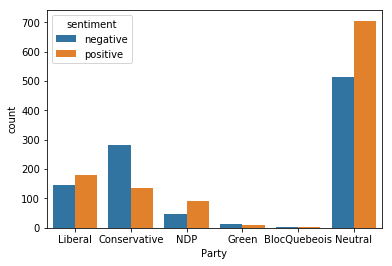

In [15]:
# Other graphs
# See sentiment distribution of each party

can_tweets['sentiment']= can_data['sentiment']
ax = sns.countplot(x = 'Party', hue= 'sentiment', data = can_tweets, order = ['Liberal','Conservative','NDP','Green','BlocQuebeois','Neutral'])
plt.show()

### Findings on sentiment distribution of each party

This is quite interesting since proportion of negative sentiment of Conservative is quite higher than Liberal. From a post-hoc perspective, this is consistent with the fact that Liberal wins the election at last.

### Bouns: Word cloud visualization 

- Visualize word cloud for positive & negative tweets

- Visualize word cloud for three major parties 

In [ ]:
# define helper function to convert token text to string
def make_str(token_lst):
    string = ''
    for token in token_lst:
        for words in token:
            string +=(' '+words)
    return string

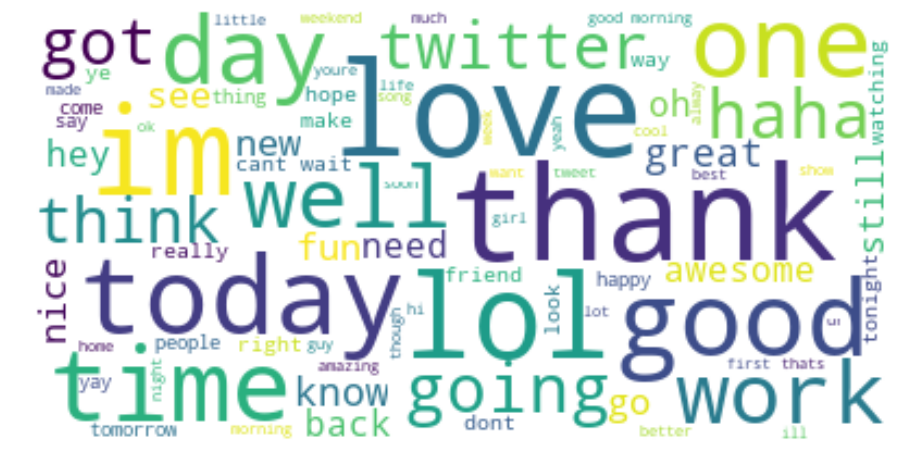

In [179]:
#Word cloud for positive genetic tweets
wordcloud = wc.WordCloud(max_font_size=60, max_words=80, background_color="white")\
.generate(make_str(gen_tweets[100001:]['token_text']))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

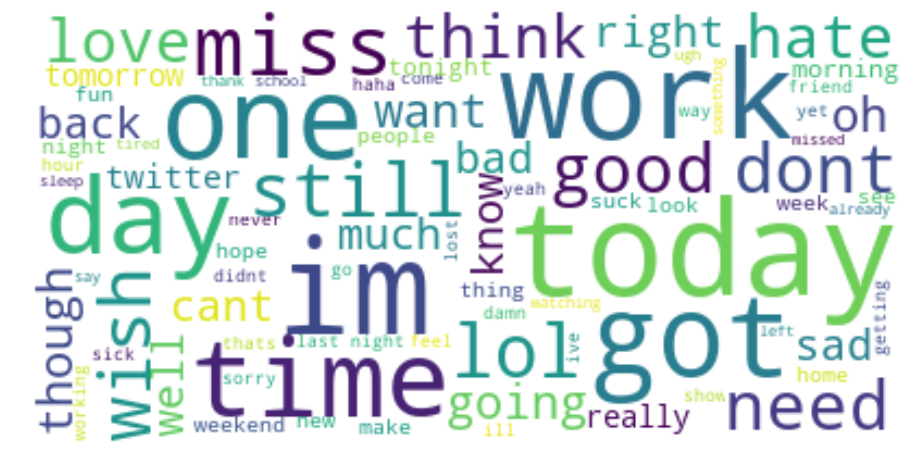

In [178]:
#Word cloud for negative genetic tweets
wordcloud = wc.WordCloud(max_font_size=60, max_words=80, background_color="white")\
.generate(make_str(gen_tweets[:99999]['token_text']))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

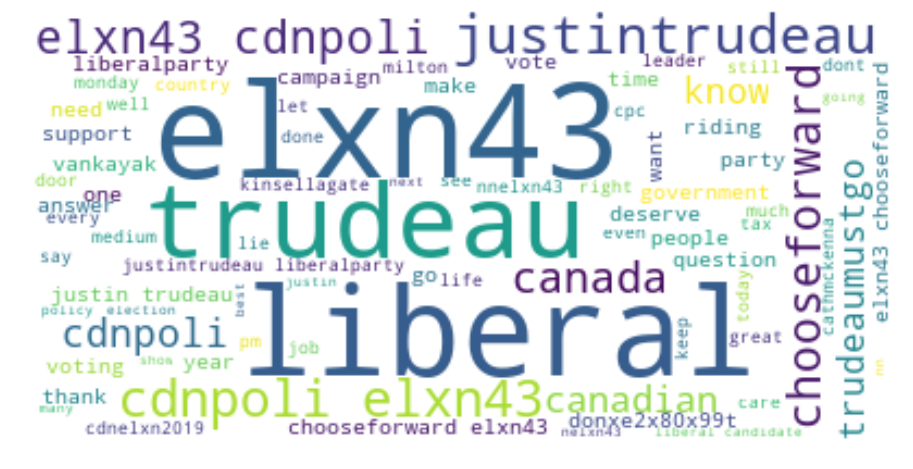

In [174]:
#Word cloud for Liberal
wordcloud = wc.WordCloud(max_font_size=60, max_words=80, background_color="white")\
.generate(make_str(can_tweets[can_tweets['Party']=='Liberal']['token_text']))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

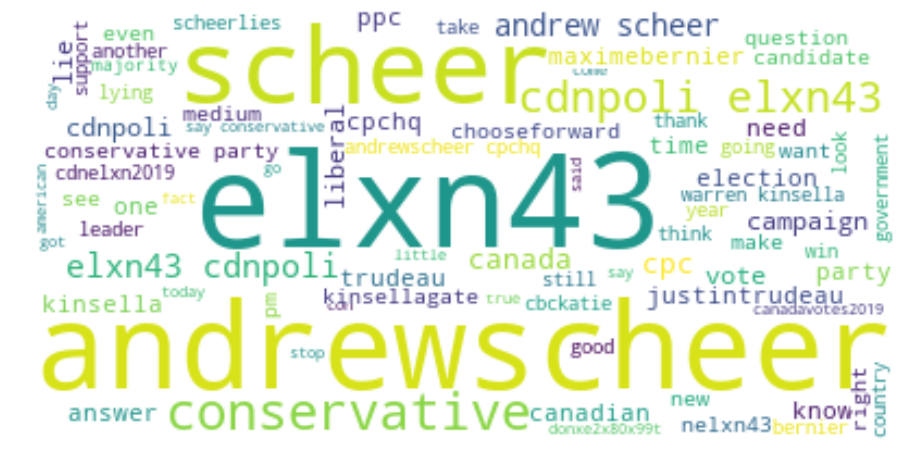

In [175]:
#Word cloud for Conservative
wordcloud = wc.WordCloud(max_font_size=60, max_words=80, background_color="white")\
.generate(make_str(can_tweets[can_tweets['Party']=='Conservative']['token_text']))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

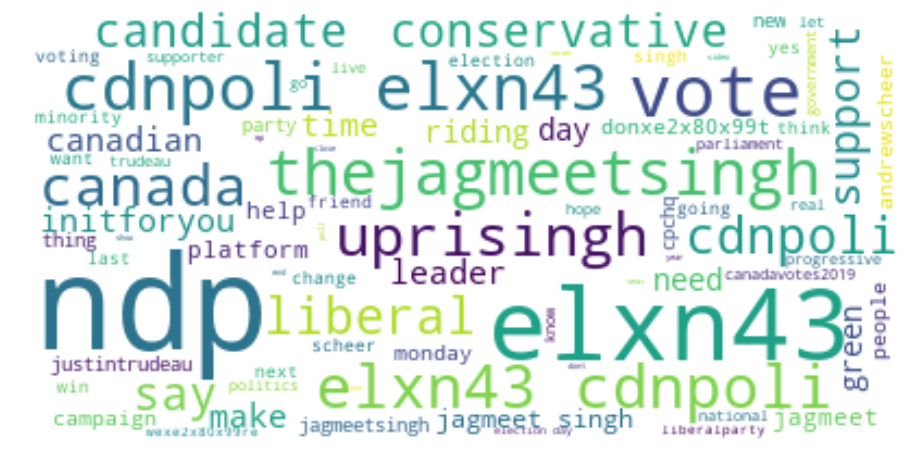

In [176]:
#Word cloud for NDP
wordcloud = wc.WordCloud(max_font_size=60, max_words=80, background_color="white")\
.generate(make_str(can_tweets[can_tweets['Party']=='NDP']['token_text']))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Part 3 Model preparation

Split the generic tweets randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles, where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, Bag of words (word frequency) and TF-IDF.

### In this part, the models we consider using are Logsitic regression, Naive Bayes, SVM and Random Forest

We do not consider KNN and desicion tree for following reasons:

### No KNN: 

One of the major drawback of KNN algorithm is its ability to deal with high dimension problems. Our problem is a high dimension problem and KNN will have a poorer performance compared to other options like SVM.

### No decision tree: 

A single decision tree is a weak predictor, but is relatively fast to build. More trees give you a more robust model and prevent overfitting. 

Desision tree have following drawbacks:

- Overfitting happens for many reasons, including presence of noise and lack of representative instances. It's possible for overfitting with one large (deep) tree. 

- Bias error happens when you place too many restrictions on target functions. For example, restricting your result with a restricting function (e.g. a linear equation) or by a simple binary algorithm (like the true/false choices in the above tree) will often result in bias.

- Variance error, refers to how much a result will change based on changes to the training set. Decision trees have high variance, which means that tiny changes in the training data have the potential to cause large changes in the final result.

We have Random Forest avaliable as an option, and decision trees are fraught with problems. A tree generated from 99 data points might differ significantly from a tree generated with just one different data point. If there was a way to generate a very large number of trees, averaging out their solutions, then you'll likely get an answer that is going to be very close to the true answer. Hence it is a slower, more complicated but more accurate and more robust algorithm than decision tree.


In [16]:
# Vectorize with Bag of words and TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Use the tokenize function we defined above as tokenizer 
# Set max_features to 5000 to save running time 
word_count_vect=CountVectorizer(tokenizer=tokenize, max_features = 5000)
tf_idf_vect=TfidfVectorizer(tokenizer=tokenize, max_features = 5000)

In [17]:
# Fit transform generic tweets data
X_wc = word_count_vect.fit_transform(gen_tweets['clean_text']).toarray()
X_tfidf = tf_idf_vect.fit_transform(gen_tweets['clean_text']).toarray()

In [18]:
# See features
wc_features=word_count_vect.get_feature_names()
tfidf_features=tf_idf_vect.get_feature_names()

In [19]:
# Split data into 70% training data and 30% test data
from sklearn.model_selection import train_test_split

X_wc_train, X_wc_test, y_wc_train, y_wc_test = train_test_split(X_wc,gen_data['class'],train_size=0.7, shuffle=True)
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tfidf,gen_data['class'],train_size=0.7, shuffle=True)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
# Scale data since some algorithms have regularizer to prevent overfitting
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_wc_train = scaler.fit_transform(X_wc_train)
X_wc_test = scaler.fit_transform(X_wc_test)
X_tf_train = scaler.fit_transform(X_tf_train)
X_tf_test = scaler.fit_transform(X_tf_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# Fit machine learning models 
# The models we consider using are Logsitic regression, Naive Bayes, SVM and Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# All models expect for the best one is comment out for saving running time

In [142]:
# Logistic Model on bag of words data
# clf = LogisticRegression(penalty='l2')
# clf.fit(X_wc_train, y_wc_train)
score = 0.7602
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.7602


In [22]:
# Logistic Model on TF-IDF data
clf = LogisticRegression(penalty='l2')
clf.fit(X_tf_train, y_tf_train)
score = clf.score(X_tf_test, y_tf_test)
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.7641


In [147]:
# Random forest on bag of words data
# rf = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=42)
# rf.fit(X_wc_train, y_wc_train)
score = 0.6025
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.6025


In [148]:
# Random forest on TF-IDF data
# rf = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=42)
# rf.fit(X_tf_train, y_tf_train)
score = 0.6189
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.6189


In [145]:
# SVM on bag of words data
# svm = SVC(gamma='auto', kernel='linear')
# # This training process takes exceptional long time, hence we reduce the size of training set as limited time constrain
# svm.fit(X_wc_train[0:5000], y_wc_train[0:5000])
score = 0.6685
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.6685


In [146]:
# SVM on TF-IDF data
# svm = SVC(gamma='auto', kernel='linear')
# svm.fit(X_tf_train[0:5000], y_tf_train[0:5000])
score = 0.6701
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.6701


In [149]:
# Naive Bayes on bag of words data
# gnb = GaussianNB()
# gnb.fit(X_wc_train, y_wc_train)
score = 0.6334
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.6334


In [150]:
# Naive Bayes on TF-IDF data
# gnb = GaussianNB()
# gnb.fit(X_tf_train, y_tf_train)
score = 0.6267
print("Score of this model is {}".format(round(score, 5)))

Score of this model is 0.6267


## Part 4 Model implementation

Train models on the training data and apply the model to the test data to obtain an accuracy value. Evaluate the same model with best performance on the 2019 Canadian elections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?

### From Part 3, we found best model is Logistic Model, with TF-IDF vectorizer 

In [23]:
# Vectorize Canadian Election tweets
X_can = tf_idf_vect.transform(can_tweets['clean_text']).toarray()

In [27]:
# Set up labels and party info
y_can = can_data['sentiment']
# Use label same as generic model
y_can = np.where(y_can == 'positive', 4, 0)
party_can = can_tweets['Party']

In [33]:
# Check transformed Canadian election labels 
y_can

array([0, 4, 0, ..., 4, 0, 4])

In [30]:
# See score using logistic model from generic data to fit election tweets data
election_score = clf.score(X_can,y_can)
print('Using logistic model with TF_IDF method to fit election tweets data:\nAccuracy is {}%'.format(round(election_score*100,4)))

Using logistic model with TF_IDF method to fit election tweets data:
Accuracy is 60.4313%


In [43]:
# Visualize more about the result
# helper function: plot confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(confusion_matrix, class_names):
    print("Confusion Matrix : ")
    fig, ax = plt.subplots()
    # create heatmap
    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g',\
                xticklabels=class_names, yticklabels=class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    return None

Confusion Matrix : 


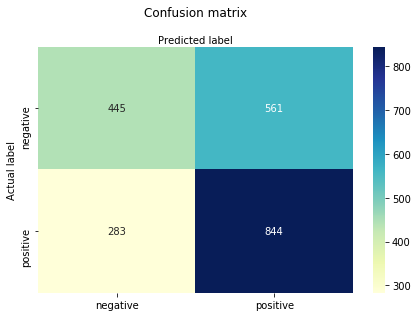

In [44]:
# See confusion matrix
con_mat = confusion_matrix(y_can, clf.predict(X_can))
plot_confusion_matrix(con_mat, class_names=['negative','positive'] )

### Findings on fitting logistic model to election tweets data

Accuracy is 60.43%, and major misclassified problem is predicting positive while true value is negative.

Negative class accuracy is lower than 50%.

### Next, see sentiment predictions for separate parties --- Liberal, Conservative and NDP

In [70]:
# Find related index of tweets from 3 major parties 
cp_idx=np.where(party_can=='Conservative')
lp_idx = np.where(party_can == 'Liberal')
ndp_idx = np.where(party_can == 'NDP')

In [72]:
# Select sub-set of three parties 

X_cp, y_cp = X_can[cp_idx], y_can[cp_idx]
X_lp, y_lp = X_can[lp_idx], y_can[lp_idx]
X_ndp, y_ndp = X_can[ndp_idx], y_can[ndp_idx]


Liberal tweets data:
Accuracy is 63.4146%
Confusion Matrix : 


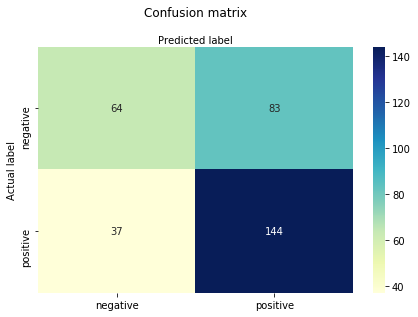

In [76]:
# Check results of three parties 

# Liberals
lp_score = clf.score(X_lp,y_lp)
lp_cm = confusion_matrix(y_lp, clf.predict(X_lp))
print('Liberal tweets data:\nAccuracy is {}%'.format(round(lp_score*100,4)))
plot_confusion_matrix(lp_cm, class_names=['negative','positive'] )

Conservatives tweets data:
Accuracy is 50.0%
Confusion Matrix : 


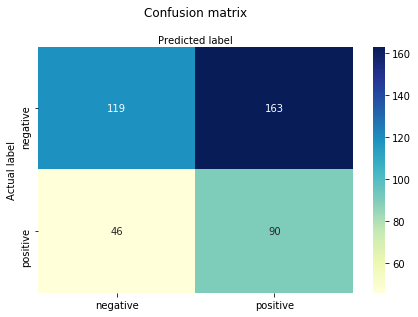

In [77]:
# Conservatives
cp_score = clf.score(X_cp,y_cp)
cp_cm = confusion_matrix(y_cp, clf.predict(X_cp))
print('Conservatives tweets data:\nAccuracy is {}%'.format(round(cp_score*100,4)))
plot_confusion_matrix(cp_cm, class_names=['negative','positive'] )

NDP tweets data:
Accuracy is 65.942%
Confusion Matrix : 


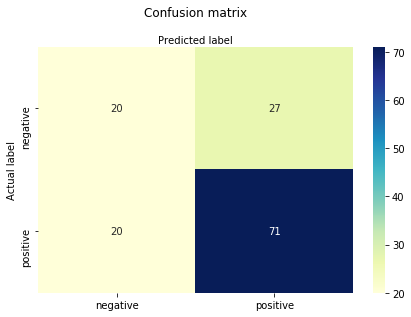

In [78]:
# NDP
ndp_score = clf.score(X_ndp,y_ndp)
ndp_cm = confusion_matrix(y_ndp, clf.predict(X_ndp))
print('NDP tweets data:\nAccuracy is {}%'.format(round(ndp_score*100,4)))
plot_confusion_matrix(p_cm, class_names=['negative','positive'] )

### Findings on model predictions by parties:

The model performance on predicting tweets labelled as Liberal and NDP is better than Conservatives. One of the major reason is that Conservative tweets have a larger proportion of 'Negative' label. And the logistic model training from generic tweets has a high tpye II error rate (predicting negative tweets to be positive). 

The results shows that NLP analytics based on tweets with specified methods used in this project might not be a good choice for political parties.

More discussion is followed in Part 5.

### Negative tweets analysis --- Negative reasons prediction

In [83]:
# See total number of negative tweets we have
can_data['sentiment'].value_counts()

positive    1127
negative    1006
Name: sentiment, dtype: int64

In [82]:
# See distribution of negative reasons
can_data['negative_reason'].value_counts()

Others                                 365
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

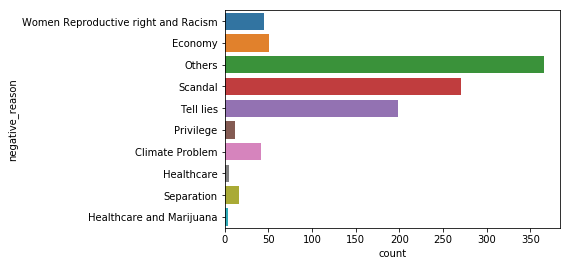

In [85]:
ax = sns.countplot(y = 'negative_reason', data = can_data)
plt.show()

### Feature Engineering: Convert 10 reasons to 4 categories

Since some of reason classes have very few observations, we decide to convert 10 reason classes to 4 categories, in order to increase model performance, and also increase the number of data avaliable for each class.

$\textbf{Reliability}$: Reasons that makes poeple feel the party is not reliable or trustable

Related reasons: Scandal, Tell lies and Privilege

$\textbf{Policy}$: Reasons related to a party's political policy and actions

Related reasons: Economy, Climate Problem, Healthcare, Healthcare and Marijuana

$\textbf{Negative social values}$: Negative thoughts and values 

Related reasons: Women Reproductive right and Racism, Separation

$\textbf{Others}$: remains as Others

In [91]:
nega_data['negative_reason'].unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'], dtype=object)

In [96]:
# Transform features
nega_data = can_data[can_data['sentiment']=='negative']
def reason_transform(reason):
    if reason in ['Scandal', 'Tell lies', 'Privilege']:
        return 'Reliability'
    elif reason in ['Economy','Climate Problem','Healthcare','Healthcare and Marijuana']:
        return 'Policy'
    elif reason in ['Women Reproductive right and Racism','Separation']:
        return 'Negative social values'
    else: 
        return 'Others'
    
nega_data['reasons']=nega_data['negative_reason'].apply(reason_transform)
nega_data.head()

,sentiment,negative_reason,text,reasons
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",Negative social values
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",Policy
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",Policy
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",Others
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",Others


In [97]:
# Preprocess text data as done before
nega_data['clean_text'] = nega_data['text'].progress_apply(clean_text)
nega_data['clean_text'] = nega_data['clean_text'].apply(can_remove_b)
nega_data.head()

Tokenizing...: 100%|██████████| 1006/1006 [00:00<00:00, 2376.88it/s]


,sentiment,negative_reason,text,reasons,clean_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",Negative social values,RosieBarton So instead of your suggestion how ...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",Policy,Brantford Its going to cost YOU 94 BILLION FOR...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",Policy,Canada taxpayers are sick tired of having the...
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",Others,CanadaVotes2019 elxn43 cdnpoli FACTS BlastFr...
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",Others,chooseforward cdnpoli elxn43nCanada Dont Make ...


In [98]:
# Tokenize and vectorize by Bag of words
wc_vect=CountVectorizer(tokenizer=tokenize)
X_neg = wc_vect.fit_transform(nega_data['clean_text']).toarray()

In [99]:
# Split data into training set and test set
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg,nega_data['reasons'],\
                                                                train_size=0.7, shuffle=True)

#### Models used for negative reason analysis:  Logistic Regression, Naive Bayes and Desicion Tree

Score of this model is 61.5894%
Confusion Matrix : 


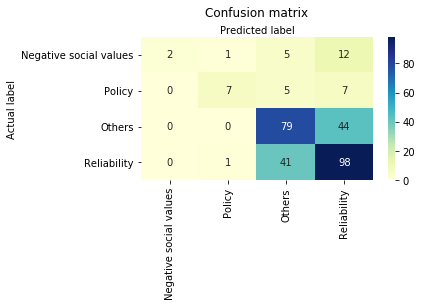

In [120]:
# Logistic model
clf2 = LogisticRegression(penalty='l2')
clf2.fit(X_neg_train, y_neg_train)
score = clf2.score(X_neg_test, y_neg_test)
reason_label = nega_data['reasons'].unique()
print("Score of this model is {}%".format(round(score*100, 4)))
cm1 = confusion_matrix(y_neg_test, clf2.predict(X_neg_test), labels = reason_label)
plot_confusion_matrix(cm1, class_names=reason_label )

Score of this model is 54.3046%
Confusion Matrix : 


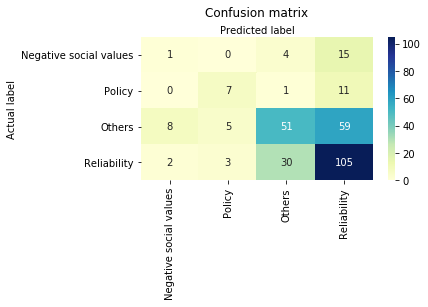

In [107]:
# Naive Bayes
gnb2 = GaussianNB()
gnb2.fit(X_neg_train, y_neg_train)
score = gnb2.score(X_neg_test, y_neg_test)
print("Score of this model is {}%".format(round(score*100, 4)))
cm2 = confusion_matrix(y_neg_test, gnb2.predict(X_neg_test), labels = reason_label)
plot_confusion_matrix(cm2, class_names=reason_label )

Score of this model is 61.5894%
Confusion Matrix : 


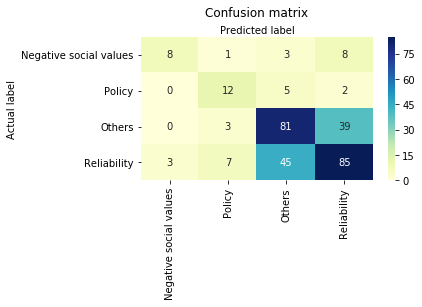

In [119]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state= 42)
dt.fit(X_neg_train, y_neg_train)
score = dt.score(X_neg_test, y_neg_test)
print("Score of this model is {}%".format(round(score*100, 4)))
cm3 = confusion_matrix(y_neg_test, dt.predict(X_neg_test), labels = reason_label)
plot_confusion_matrix(cm3, class_names=reason_label )

## Part 5: Results and Discussion


### 1. Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value.

The best model we found for sentiment prediction is Logistic Model, with TF-IDF vectorized data. It reaches an accuracy of 76.41% However, when apply this model to Canadian election tweets, the accracy falls to 60.43%. Then we analyze confusion matrices and decompose the predictions by parties, and we figure out that our logistic model have a high Tpye II error rate(predicting negative tweets to positive). From group bar chart of parties and sentiments, we found that conservative party has a significant higher proportion of negative tweets than Liberals and NDP. This is also the major reason for the decrease of the accuracy of our model: wrongly predict negative conservative tweets to postive ones. In pubilc view, although Conservative has been mentioned most, Liberals and NDP are more positive than Conservatives, which is some what consistent with the election results. 

### 2. For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. 

Logistic model have the best performance and here are some possible reasons for mis-predictions:

- Ambiguous boundaries between classes: 

In this question, we have coverted 10 class of negative reasons to 4. However, the boundaries between classes is sometimes ambiguous. There may exists some tweets belongs to both classes. 


- Unbalanced data leads introduces bias to model

Because the data is unbalanced, our model is more trained to regonize patterns of 'Policy' and 'Other'. Confusion matrix of the logistic model implies that our model is more likely to classify a tweet to Other and Reliability.

### 3.For both models, suggest one way you can improve the accuracy of your models.

There are several ways of improvement:

- Cross validation and hyperparameter tuning

As time constrained, we did not perform cross validation and hyper-parameter tuning. By using tuning method like grid-search we might find a better parameter (i.e. C and regularizer for logistic regression) to find a better balance of variance-bias trade off.

- Deep learning Algorithm

NLP problem usually has a high dimension sparse matrix and sentiment analysis is a kind of pattern recognition task. Therefore, generally speaking, Deep Learning algorithm like RNN and LSTM may have a better performance.
